In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras_tuner
import tensorflow as tf
import spacy
import nltk
import visualkeras

from sklearn.model_selection import train_test_split
from keras import layers
from keras.datasets import fashion_mnist, imdb, cifar10
from keras.metrics import Precision, Recall, F1Score
from keras.utils import to_categorical, pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, LSTM, Bidirectional, Dropout, Conv2D, MaxPooling2D, Input, Embedding, SimpleRNN, BatchNormalization
from keras.regularizers import l2, l1
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Nadam, Adamax, Ftrl
from keras.constraints import max_norm
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [42]:
def plot_history(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    val_acc_values = history_dict['val_accuracy']

    epochs = range(1, len(history_dict['accuracy']) + 1)

    plt.style.use('dark_background')

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_values, color='lime', label='Training loss')
    plt.plot(epochs, val_loss_values, color='orangered', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(linestyle='--')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_dict['accuracy'], color='lime', label='Training acc')
    plt.plot(epochs, val_acc_values, color='orangered', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(linestyle='--')
    
    plt.tight_layout()
    plt.show()

In [43]:
def plot_precision_recall(history):
    precision_values = [history.history[f'precision_class{i}'][-1] for i in range(10)]
    recall_values = [history.history[f'recall_class{i}'][-1] for i in range(10)]

    classes = [str(i) for i in range(10)]
    width = 0.35
    x = range(len(classes))

    plt.figure(figsize=(14, 5))

    plt.bar(x, precision_values, width, label='Precision')
    plt.bar([i + width for i in x], recall_values, width, label='Recall')

    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.title('Precision and Recall for Each Class')
    plt.xticks([i + width/2 for i in x], classes)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.legend()
    plt.grid(axis='y', linestyle='--')

    plt.show()

In [44]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

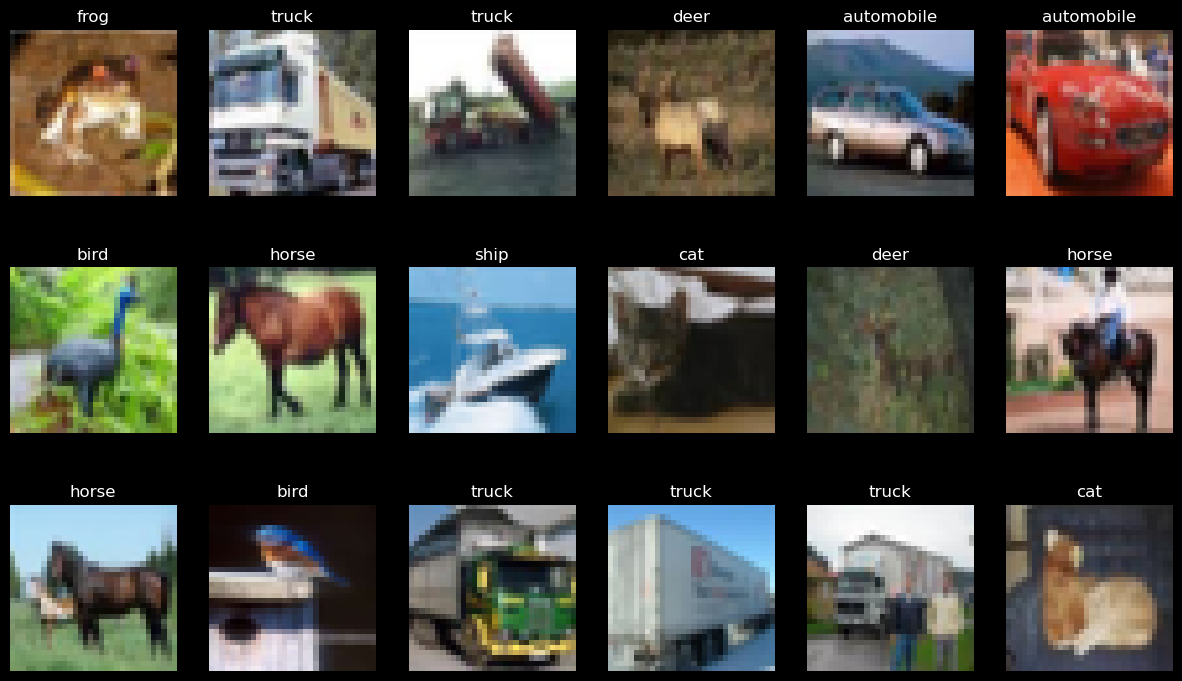

In [45]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(15, 18))

for i in range(18):
        plt.subplot(6, 6, i+1)
        plt.imshow(X_train[i])
        plt.title(class_names[y_train[i][0]])
        plt.axis('off')

plt.show()

In [46]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train, X_test = X_train / 255., X_test / 255.

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [47]:
precision_per_class = [Precision(class_id=i, name=f'precision_class{i}') for i in range(10)]
recall_per_class = [Recall(class_id=i, name=f'recall_class{i}') for i in range(10)]

all_metrics = ['accuracy'] + precision_per_class + recall_per_class

In [48]:
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
conv_base.trainable = False

class MyFilterModelMP():
    def build(self):
        model = Sequential([
            conv_base,
            Flatten(),
            Dense(10, activation='softmax')
        ])

        model.compile(optimizer=Adam(learning_rate=0.0005),
                      loss='categorical_crossentropy',
                      metrics=all_metrics)

        return model


In [49]:
class MyVGGModel():
    def build(self):
        regul_coeff = 0.0001
        model = Sequential([
            Conv2D(32, (3, 3), activation="relu", input_shape=(32, 32, 3), kernel_regularizer=l2(regul_coeff), padding='same'),
            BatchNormalization(),
            Conv2D(32, (3, 3), activation="relu", kernel_regularizer=l2(regul_coeff), padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(rate=0.4),

            Conv2D(64, (3, 3), activation="relu", kernel_regularizer=l2(regul_coeff), padding='same'),
            BatchNormalization(),
            Conv2D(64, (3, 3), activation="relu", kernel_regularizer=l2(regul_coeff), padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(rate=0.3),

            Conv2D(128, (3, 3), activation="relu", kernel_regularizer=l2(regul_coeff), padding='same'),
            BatchNormalization(),
            Conv2D(128, (3, 3), activation="relu", kernel_regularizer=l2(regul_coeff), padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(rate=0.2),

            Conv2D(256, (3, 3), activation="relu", kernel_regularizer=l2(regul_coeff), padding='same'),
            BatchNormalization(),
            Conv2D(256, (3, 3), activation="relu", kernel_regularizer=l2(regul_coeff), padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(rate=0.1),

            Flatten(),
            Dense(256, activation="relu"), 
            Dense(10, activation="softmax")
        ])

        model.compile(optimizer=Adam(learning_rate=0.0005),
                      loss='categorical_crossentropy',
                      metrics=all_metrics)

        return model

In [50]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.12,
    height_shift_range=0.12,
)

train_generator = datagen.flow(X_train, y_train, batch_size=64)

In [51]:
early_stopping = EarlyStopping(monitor='val_loss', patience=35, restore_best_weights=True, start_from_epoch=30, verbose=1)

In [52]:
filtermodel = MyVGGModel()
model_filter = filtermodel.build()
history = model_filter.fit(
    train_generator,
    validation_data=(X_test, y_test),
    epochs=250,
    callbacks=[early_stopping]
)

Epoch 1/250


/home/alex/Python_projects/HW_Data_Science/.conda/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  6/782 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.1360 - loss: 3.4226 - precision_class0: 0.1736 - precision_class1: 0.1133 - precision_class2: 0.1946 - precision_class3: 0.0000e+00 - precision_class4: 0.1587 - precision_class5: 0.1177 - precision_class6: 0.1865 - precision_class7: 0.1028 - precision_class8: 0.1444 - precision_class9: 0.0978 - recall_class0: 0.0832 - recall_class1: 0.0509 - recall_class2: 0.0486 - recall_class3: 0.0000e+00 - recall_class4: 0.0917 - recall_class5: 0.0777 - recall_class6: 0.1357 - recall_class7: 0.0227 - recall_class8: 0.0517 - recall_class9: 0.0691                                                         

W0000 00:00:1707566756.561695    6008 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


782/782 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.3449 - loss: 1.9465 - precision_class0: 0.5109 - precision_class1: 0.5117 - precision_class2: 0.3735 - precision_class3: 0.3266 - precision_class4: 0.4308 - precision_class5: 0.4428 - precision_class6: 0.5116 - precision_class7: 0.5379 - precision_class8: 0.5478 - precision_class9: 0.5261 - recall_class0: 0.1767 - recall_class1: 0.2293 - recall_class2: 0.0498 - recall_class3: 0.0332 - recall_class4: 0.0877 - recall_class5: 0.0933 - recall_class6: 0.1716 - recall_class7: 0.1533 - recall_class8: 0.2554 - recall_class9: 0.1971 - val_accuracy: 0.4628 - val_loss: 1.7510 - val_precision_class0: 0.8705 - val_precision_class1: 0.6890 - val_precision_class2: 0.6820 - val_precision_class3: 0.5370 - val_precision_class4: 0.6245 - val_precision_class5: 0.7400 - val_precision_class6: 0.3255 - val_precision_class7: 0.7913 - val_precision_class8: 0.6435 - val_precision_class9: 0.6007 - val_recall_class0: 0.1680 - val_recall_class1: 0.5850 - val

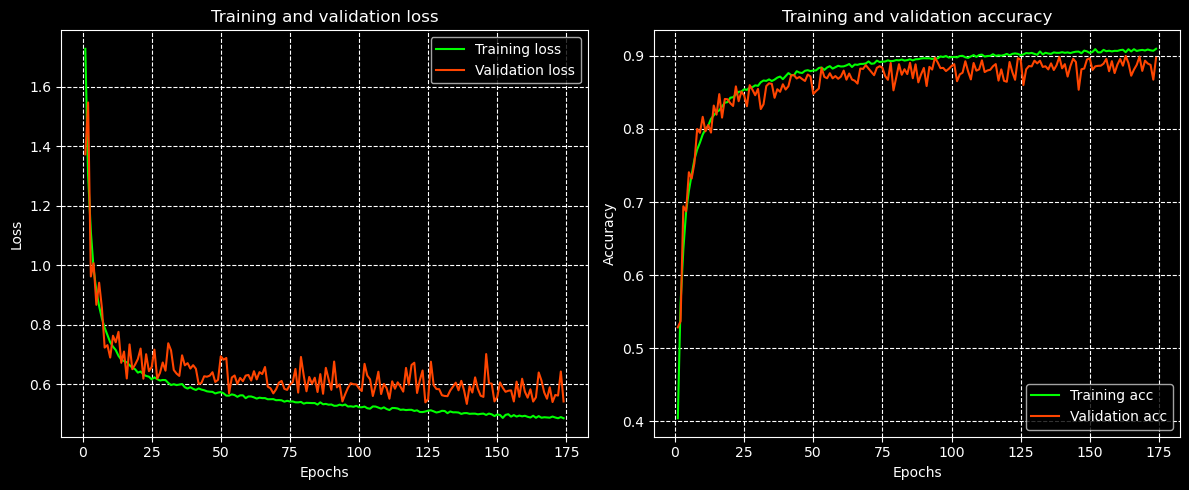

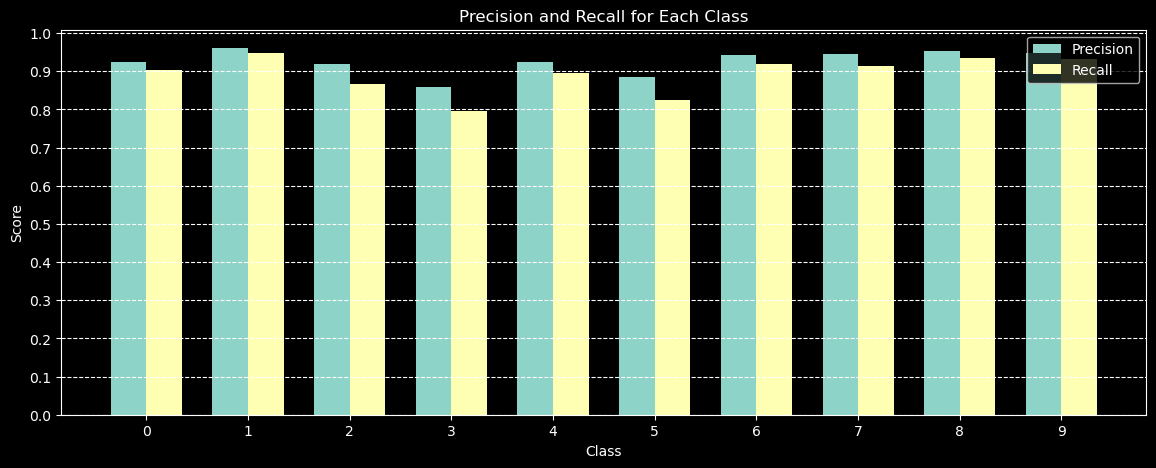

In [ ]:
plot_history(history)
plot_precision_recall(history)

In [ ]:
test_acc = model_filter.evaluate(X_test, y_test)
print("test acc:", test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8968 - loss: 0.5344 - precision_class0: 0.9102 - precision_class1: 0.9609 - precision_class2: 0.9034 - precision_class3: 0.8301 - precision_class4: 0.9105 - precision_class5: 0.8934 - precision_class6: 0.8963 - precision_class7: 0.9549 - precision_class8: 0.9555 - precision_class9: 0.9345 - recall_class0: 0.8926 - recall_class1: 0.9528 - recall_class2: 0.8540 - recall_class3: 0.7640 - recall_class4: 0.8832 - recall_class5: 0.7977 - recall_class6: 0.9177 - recall_class7: 0.9103 - recall_class8: 0.9051 - recall_class9: 0.9361
test acc: [0.5345360040664673, 0.8985000252723694, 0.9169231057167053, 0.9606854915618896, 0.901168942451477, 0.8391451239585876, 0.8942598104476929, 0.8949152827262878, 0.8991354703903198, 0.9488517642021179, 0.9553942084312439, 0.932338297367096, 0.8939999938011169, 0.953000009059906, 0.8479999899864197, 0.7459999918937683, 0.8880000114440918, 0.7919999957084656, 0.9359999895095825, 0.9089999794960022, 0.92100

In [ ]:
path = "/home/alex/Python_projects/HW_Data_Science/models/model_filter_drop_re_vgg16.h5"
model_filter.save(path)

In [ ]:
path = "/home/alex/Python_projects/HW_Data_Science/models/model_filter_drop_re_vgg16.h5"
loaded_model = load_model(path)

loaded_model.summary()
# visualkeras.layered_view(model_filter, legend=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)        │        896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization             │ (None, 32, 32, 32)        │        128 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)        │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)        │        128 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)        │     18,496 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)        │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)        │     36,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)        │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)         │     73,856 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)         │        512 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)         │    147,584 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)         │        512 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 256)         │    295,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_6           │ (None, 4, 4, 256)         │      1,024 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 256)         │    590,080 │
├─────────────────────────────────┼───────────────────────────┼──────────

 Total params: 1,441,068 (5.50 MB)

 Trainable params: 1,439,146 (5.49 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 2 (12.00 B)

AttributeError: 'Conv2D' object has no attribute 'output_shape'

In [ ]:
test_acc = loaded_model.evaluate(X_test, y_test)
print("test acc:", test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8968 - loss: 0.5344 - precision_class0: 0.9102 - precision_class1: 0.9609 - precision_class2: 0.9034 - precision_class3: 0.8301 - precision_class4: 0.9105 - precision_class5: 0.8934 - precision_class6: 0.8963 - precision_class7: 0.9549 - precision_class8: 0.9555 - precision_class9: 0.9345 - recall_class0: 0.8926 - recall_class1: 0.9528 - recall_class2: 0.8540 - recall_class3: 0.7640 - recall_class4: 0.8832 - recall_class5: 0.7977 - recall_class6: 0.9177 - recall_class7: 0.9103 - recall_class8: 0.9051 - recall_class9: 0.9361
test acc: [0.5345360040664673, 0.8985000252723694, 0.9169231057167053, 0.9606854915618896, 0.901168942451477, 0.8391451239585876, 0.8942598104476929, 0.8949152827262878, 0.8991354703903198, 0.9488517642021179, 0.9553942084312439, 0.932338297367096, 0.8939999938011169, 0.953000009059906, 0.8479999899864197, 0.7459999918937683, 0.8880000114440918, 0.7919999957084656, 0.9359999895095825, 0.9089999794960022, 0.92100

In [ ]:
import cv2

import urllib.request
url = "https://www.usatoday.com/gcdn/authoring/authoring-images/2023/12/08/USAT/71852301007-1569872652.jpg"
resp = urllib.request.urlopen(url)
image = np.asarray(bytearray(resp.read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)

# Convert the image from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
# Resize it to 32x32 pixels
image = cv2.resize(image, (32,32))

# Normalize the image
image = image.astype('float32')/255.

# Add an extra dimension because the model expects a batch of images
image = image.reshape((1, 32, 32, 3))

In [ ]:
prediction = loaded_model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [ ]:
predicted_class = prediction.argmax()

print('Predicted class: ', class_names[predicted_class])

Predicted class:  deer
